[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Cage6666/fdudataapp/blob/master/Classification/Classification.ipynb)

# 决策树

- ID3（基于信息增益）
- C4.5（基于信息增益比）
- CART（gini指数）

注：一些辅助理解的公式
#### entropy：$H(x) = -\sum_{i=1}^{n}p_i\log{p_i}$

#### conditional entropy: $H(X|Y)=\sum{P(X|Y)}\log{P(X|Y)}$

#### information gain : $g(D, A)=H(D)-H(D|A)$

#### information gain ratio: $g_R(D, A) = \frac{g(D,A)}{H(A)}$

#### gini index:$Gini(D)=\sum_{k=1}^{K}p_k\log{p_k}=1-\sum_{k=1}^{K}p_k^2$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter
import math
from math import log

import pprint

### 先用CAR数据集理解决策树的实现


In [0]:
def create_data():
    datasets = [['晴', '热', '大', '无', '否'],
               ['晴', '热', '大', '有', '否'],
               ['多云', '是', '否', '好', '是'],
               ['雨', '中', '大', '无', '是'],
               ['雨', '冷', '正常', '无', '是'],
               ['雨', '冷', '正常', '有', '否'],
               ['多云', '冷', '正常', '有', '是'],
               ['晴', '中', '大', '无', '否'],
               ['晴', '冷', '正常', '无', '是'],
               ['雨', '中', '正常', '无', '是'],
               ['晴', '中', '正常', '有', '是'],
               ['多云', '中', '大', '有', '是'],
               ['多云', '热', '正常', '无', '是'],
               ['雨', '中', '大', '有', '否']
              
               ]
    labels = [u'天况', u'温度', u'湿度', u'风况', u'分类']
    # 返回数据集和每个维度的名称
    return datasets, labels
datasets, labels = create_data()
train_data = pd.DataFrame(datasets, columns=labels)


In [0]:
train_data

,天况,温度,湿度,风况,分类
0,晴,热,大,无,否
1,晴,热,大,有,否
2,多云,是,否,好,是
3,雨,中,大,无,是
4,雨,冷,正常,无,是
5,雨,冷,正常,有,否
6,多云,冷,正常,有,是
7,晴,中,大,无,否
8,晴,冷,正常,无,是
9,雨,中,正常,无,是


In [0]:
# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
    return ent

# 经验条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum([(len(p)/data_length)*calc_ent(p) for p in feature_sets.values()])
    return cond_ent

# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent

def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [0]:
info_gain_train(np.array(train_data))

特征(天况) - info_gain - 0.247
特征(温度) - info_gain - 0.118
特征(湿度) - info_gain - 0.251
特征(风况) - info_gain - 0.080


'特征(湿度)的信息增益最大，选择为根节点特征'

---

利用ID3算法生成决策树

In [0]:
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {'label:': self.label, 'feature': self.feature, 'tree': self.tree}

    def __repr__(self):
        return '{}'.format(self.result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)
    
class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p)/data_length)*self.calc_ent(p) for p in feature_sets.values()])
        return cond_ent

    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :-1], train_data.iloc[:, -1], train_data.columns[:-1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True,
                        label=y_train.iloc[0])

        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,构建Ag子集
        node_tree = Node(root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] == f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        # pprint.pprint(node_tree.tree)
        return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

In [0]:
dt = DTree()
tree = dt.fit(train_data)

In [0]:
tree

{'label:': None, 'feature': 2, 'tree': {'正常': {'label:': None, 'feature': 0, 'tree': {'雨': {'label:': None, 'feature': 1, 'tree': {'无': {'label:': '是', 'feature': None, 'tree': {}}, '有': {'label:': '否', 'feature': None, 'tree': {}}}}, '多云': {'label:': '是', 'feature': None, 'tree': {}}, '晴': {'label:': '是', 'feature': None, 'tree': {}}}}, '大': {'label:': None, 'feature': 0, 'tree': {'晴': {'label:': '否', 'feature': None, 'tree': {}}, '雨': {'label:': None, 'feature': 1, 'tree': {'无': {'label:': '是', 'feature': None, 'tree': {}}, '有': {'label:': '否', 'feature': None, 'tree': {}}}}, '多云': {'label:': '是', 'feature': None, 'tree': {}}}}, '否': {'label:': '是', 'feature': None, 'tree': {}}}}

In [0]:
dt.predict(['晴', '中', '大', '无'])

'否'

---

## sklearn.tree.DecisionTreeClassifier

Scikit Learn是python最常用的机器学习库之一，接下来我们基于拍拍贷数据，使用sklearn库实现一下决策树模型的预测

In [0]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree
from sklearn import metrics
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


在excel中，发现Userinfo_2&3是用户的城市信息，其地域绝对是能反映信息的，因此首先对这进行处理。根据城市gdp、人口将城市划分为6档，1为北上广这样人口最大GDP最发达的国家，依次类推。以下导入的是已经变换完成的数据。将两个数据合并起来一起操作。

In [3]:
train = pd.read_csv('PPDtrain.csv',engine = 'python')
test = pd.read_csv('PPDtest.csv',engine = 'python')

In [0]:
data = train.append(test)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [0]:
data.describe()

,Education_Info1,Education_Info5,Idx,SocialNetwork_1,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_15,SocialNetwork_16,SocialNetwork_17,SocialNetwork_2,SocialNetwork_3,SocialNetwork_4,SocialNetwork_5,SocialNetwork_6,SocialNetwork_7,SocialNetwork_8,SocialNetwork_9,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,...,WeblogInfo_27,WeblogInfo_28,WeblogInfo_29,WeblogInfo_3,WeblogInfo_30,WeblogInfo_31,WeblogInfo_32,WeblogInfo_33,WeblogInfo_34,WeblogInfo_35,WeblogInfo_36,WeblogInfo_37,WeblogInfo_38,WeblogInfo_39,WeblogInfo_4,WeblogInfo_40,WeblogInfo_41,WeblogInfo_42,WeblogInfo_43,WeblogInfo_44,WeblogInfo_45,WeblogInfo_46,WeblogInfo_47,WeblogInfo_48,WeblogInfo_49,WeblogInfo_5,WeblogInfo_50,WeblogInfo_51,WeblogInfo_52,WeblogInfo_53,WeblogInfo_54,WeblogInfo_55,WeblogInfo_56,WeblogInfo_57,WeblogInfo_58,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_9,target
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,29747.000000,29747.000000,29747.000000,970.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,28349.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.000000,29747.0,28349.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,28349.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.063000,0.032467,46318.673267,0.001233,75.211233,-0.999267,-0.745033,0.221167,0.062033,0.027967,0.016633,0.253467,0.031733,8.552363e+01,5.014967,10.199067,-0.262167,-0.969867,27.577533,35.516167,19.10360,0.970300,13.204600,1.249900,1.509768e+04,1.324802e+04,1349.593933,1.853184e+04,8468.346800,14.141000,146.614300,140.123300,65.095533,11.360800,203.103500,72.267733,2.867033,30.702833,1.010700,20.155033,...,0.238310,0.013178,0.024944,1.308247,0.139342,0.003328,0.005681,0.302652,0.020237,0.010657,0.192860,0.010791,0.019498,0.104851,3.025962,0.002353,0.000403,0.051266,0.001277,0.000235,0.012472,0.000773,0.001647,0.021179,0.0,1.816960,0.012233,0.009967,0.001833,0.006833,0.006167,0.000800,0.019067,0.016133,0.002633,2.948711,10.632800,0.657633,0.120567,0.073267
std,0.242967,0.177239,26640.397805,0.036948,742.978305,0.052911,0.441473,0.420545,0.242598,0.164880,0.127895,0.437296,0.198816,6.362796e+03,73.277866,200.455689,32.497465,0.183193,235.580078,135.954587,31.97427,1.648507,12.672351,15.382863,2.407289e+04,2.137895e+04,5013.046131,2.975898e+04,13706.156775,26.565831,161.300833,150.088588,52.359378,34.232729,217.851007,80.862299,7.786898,45.296624,1.685194,15.791558,...,0.881495,0.126610,0.176960,7.866457,0.458726,0.083756,0.079084,1.169007,0.150953,0.104948,0.766459,0.113550,0.151050,0.401954,3.772421,0.070498,0.020081,0.444712,0.039304,0.015339,0.169278,0.028980,0.042179,0.222503,0.0,1.701177,0.139108,0.124638,0.051930,0.120501,0.115740,0.036507,0.183587,0.169727,0.063455,3.770300,16.097588,2.622133,1.337519,0.260578
min,0.000000,0

接下来还有两步数据清洗工作要做：

第一步，观察到，UserInfo_10	UserInfo_11	UserInfo_12这三列有着不少的空缺值(NaN)。下一步去掉缺失值和值为0较多的变量。

In [0]:
#去掉超过95%列值为NaN或0的变量
final_data = data.loc[:, (data==np.nan).mean() < .95]
final_data = final_data.loc[:, (data==0).mean() < .95]
#把余下少量的缺失值填为-99(一般会填为0或-1，但在许多列中存在0和-1，故这里选用-99)。
final_data = final_data.fillna(-99)

In [0]:
final_data.describe()

,Education_Info1,Idx,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_17,SocialNetwork_3,SocialNetwork_4,SocialNetwork_5,SocialNetwork_6,SocialNetwork_7,SocialNetwork_8,SocialNetwork_9,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,...,ThirdParty_Info_Period7_7,ThirdParty_Info_Period7_8,ThirdParty_Info_Period7_9,UserInfo_1,UserInfo_10,UserInfo_11,UserInfo_12,UserInfo_13,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_2,UserInfo_20,UserInfo_3,UserInfo_4,UserInfo_5,UserInfo_6,UserInfo_9,WeblogInfo_1,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,WeblogInfo_2,WeblogInfo_24,WeblogInfo_27,WeblogInfo_3,WeblogInfo_30,WeblogInfo_33,WeblogInfo_36,WeblogInfo_39,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,target
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000,3.000000e+04,...,30000.0000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0000,30000.0000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.063000,46318.673267,75.211233,-0.999267,-0.745033,0.221167,0.062033,0.253467,8.552363e+01,5.014967,10.199067,-0.262167,-0.969867,27.577533,35.516167,19.10360,0.970300,13.204600,1.249900,1.509768e+04,1.324802e+04,1349.593933,1.853184e+04,8468.346800,14.141000,146.614300,140.123300,65.095533,11.360800,203.103500,72.267733,2.867033,30.702833,1.010700,20.155033,2.040933,2.412573e+04,2.114692e+04,2201.432733,2.896955e+04,...,6.3222,2.097733,-0.888467,3.199467,-18.66880,-62.339700,-62.234133,-42.316967,3.418233,2.878367,1.469833,9.73180,-8.858900,3.394200,-69.278600,4.670133,3.326267,1.654067,-28.543800,-69.205333,-95.727833,0.761967,1.020033,2.622100,5.345567,1.645100,-5.3472,-0.4819,-0.598600,-95.75670,-0.696733,-0.534800,-0.643667,-0.730933,-2.588867,-3.731333,-2.661867,10.632800,0.657633,0.073267
std,0.242967,26640.397805,742.978305,0.052911,0.441473,0.420545,0.242598,0.437296,6.362796e+03,73.277866,200.455689,32.497465,0.183193,235.580078,135.954587,31.97427,1.648507,12.672351,15.382863,2.407289e+04,2.137895e+04,5013.046131,2.975898e+04,13706.156775,26.565831,161.300833,150.088588,52.359378,34.232729,217.851007,80.862299,7.786898,45.296624,1.685194,15.791558,24.530844,3.575943e+04,3.403107e+04,6771.159722,4.728239e+04,...,58.0119,25.654984,1.177146,2.330063,39.01976,47.869285,48.007555,50.202514,1.169142,1.408251,0.941835,13.61063,59.254783,1.518162,45.401164,2.062587,1.529998,0.583845,46.127728,45.514081,17.956376,4.292240,2.845517,4.748885,8.220961,3.551586,22.6546,9.1795,9.117363,17

经过以上操作，可以看到数据维度从211降至171。
第二步，观察到UserInfo_8这一列是文本变量，无法放入模型进行训练，这里采用独热编码(OneHotEncoder)的方式进行处理。独热编码与前面对于城市的序号编码有着本质不同：序号编码的数字隐含着数字顺序的信息，独热编码旨在消除这一信息；不同运营商之前是没有高低之分的，与城市大小不同。

In [0]:
#将运营商信息变为哑变量
cat_feats = ['UserInfo_8']
final_data = pd.get_dummies(final_data,columns=cat_feats,drop_first=True)

#其余的文本型变量意义不明，暂时先删掉，建议大家可以尝试把他们做成哑变量加入模型训练
final_data = final_data.select_dtypes(exclude=['object'])

In [0]:
final_data.head()

,Education_Info1,Idx,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_17,SocialNetwork_3,SocialNetwork_4,SocialNetwork_5,SocialNetwork_6,SocialNetwork_7,SocialNetwork_8,SocialNetwork_9,ThirdParty_Info_Period1_1,ThirdParty_Info_Period1_10,ThirdParty_Info_Period1_11,ThirdParty_Info_Period1_12,ThirdParty_Info_Period1_13,ThirdParty_Info_Period1_14,ThirdParty_Info_Period1_15,ThirdParty_Info_Period1_16,ThirdParty_Info_Period1_17,ThirdParty_Info_Period1_2,ThirdParty_Info_Period1_3,ThirdParty_Info_Period1_4,ThirdParty_Info_Period1_5,ThirdParty_Info_Period1_6,ThirdParty_Info_Period1_7,ThirdParty_Info_Period1_8,ThirdParty_Info_Period1_9,ThirdParty_Info_Period2_1,ThirdParty_Info_Period2_10,ThirdParty_Info_Period2_11,ThirdParty_Info_Period2_12,ThirdParty_Info_Period2_13,ThirdParty_Info_Period2_14,ThirdParty_Info_Period2_15,ThirdParty_Info_Period2_16,...,UserInfo_10,UserInfo_11,UserInfo_12,UserInfo_13,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_2,UserInfo_20,UserInfo_3,UserInfo_4,UserInfo_5,UserInfo_6,UserInfo_9,WeblogInfo_1,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,WeblogInfo_2,WeblogInfo_24,WeblogInfo_27,WeblogInfo_3,WeblogInfo_30,WeblogInfo_33,WeblogInfo_36,WeblogInfo_39,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,target,UserInfo_8_,UserInfo_8_ChinaMobile,UserInfo_8_ChinaTelecom,UserInfo_8_ChinaUnicom
0,0,28564,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,0,2,29,0,23472,30939,564,36852,16995,20,260,369,150,10,490,129,2,0,1,29,0,28779,38817,488,50240,...,2.0,0.0,1.0,1.0,4,4,2,2,37.0,2,-99.0,4.0,2,2,2.0,-99.0,-99.0,0,0,4,10,3,0.0,0.0,0.0,-99.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,17,2,0,0,0,0,1
1,0,89563,-1,-1,-1,0,1,0,-1,-1,-1,-1,-1,-1,-1,35,0,4,0,9466,8951,0,13160,5257,1,57,66,44,0,103,20,0,39,0,8,0,13457,13257,231,14078,...,0.0,0.0,0.0,1.0,4,4,2,1,32.0,6,-99.0,5.0,2,2,2.0,-99.0,-99.0,0,0,11,32,7,0.0,0.0,0.0,-99.0,0.0,0.0,0.0,0.0,6.0,5.0,6.0,50,0,0,0,0,1,0
2,0,2748,319,-1,0,1,0,1,26,55,34,0,0,140,102,0,2,8,3,39369,0,205,22880,16284,3,250,0,94,2,174,74,3,0,2,20,8,89416,0,6651,49258,...,0.0,-99.0,-99.0,-99.0,3,3,1,2,24.0,6,-99.0,6.0,6,1,2.0,-99.0,-99.0,0,0,0,0,0,0.0,0.0,0.0,-99.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0,0,0,0,1,0,0
3,0,64456,-1,-1,-1,0,0,0,-1,-1,-1,-1,-1,-1,-1,0,0,1,0,467,353,0,820,0,1,7,4,6,0,11,0,0,0,4,7,0,13789,17631,0,21583,...,0.0,-99.0,-99.0,-99.0,3,3,1,2,25.0,1,-99.0,5.0,1,1,2.0,-99.0,-99.0,0,0,2,2,1,0.0,0.0,0.0,-99.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5,2,0,0,0,0,0
4,1,73732,-1,-1,-1,1,0,0,-1,-1,-1,-1,-1,-1,-1,22,0,6,2,14212,6080,0,7511,12781,6,58,39,38,0,58,39,0,5,0,8,1,7397,4649,0,5483,...,0.0,-99.0,-99.0,-99.0,2,2,3,1,23.0,2,-99.0,5.0,2,1,2.0,-99.0,1.0,0,0,3,6,4,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,13,0,0,0,1,0,0


In [0]:
final_data.dtypes

Education_Info1                 int64
Idx                             int64
SocialNetwork_10                int64
SocialNetwork_11                int64
SocialNetwork_12                int64
SocialNetwork_13                int64
SocialNetwork_14                int64
SocialNetwork_17                int64
SocialNetwork_3                 int64
SocialNetwork_4                 int64
SocialNetwork_5                 int64
SocialNetwork_6                 int64
SocialNetwork_7                 int64
SocialNetwork_8                 int64
SocialNetwork_9                 int64
ThirdParty_Info_Period1_1       int64
ThirdParty_Info_Period1_10      int64
ThirdParty_Info_Period1_11      int64
ThirdParty_Info_Period1_12      int64
ThirdParty_Info_Period1_13      int64
ThirdParty_Info_Period1_14      int64
ThirdParty_Info_Period1_15      int64
ThirdParty_Info_Period1_16      int64
ThirdParty_Info_Period1_17      int64
ThirdParty_Info_Period1_2       int64
ThirdParty_Info_Period1_3       int64
ThirdParty_I

首先观察本次预测的目标变量target，即违约与否。会发现大部分人是不违约的。


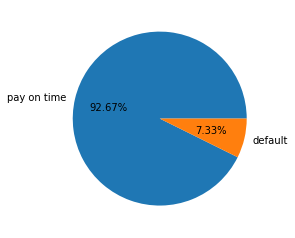

In [0]:
# 为确保绘制的饼图为圆形，需执行如下代码
plt.axes(aspect = 'equal')
# 统计交易是否为欺诈的频数
counts = final_data.target.value_counts()

# 绘制饼图
plt.pie(x = counts, # 绘图数据
        labels=pd.Series(counts.index).map({1:'default',0:'pay on time'}), # 添加文字标签
        autopct='%.2f%%' # 设置百分比的格式，这里保留一位小数
       )
# 显示图形
plt.show()

这样的话，即使是拍脑袋的结果，把所有违约预测成不违约，准确率都高达92.67%。违约变量占的比重太小，很难得到对违约用户正确的预测，这被称为不平衡数据，需要进行SMOTE抽样，将在完成特征工程后进行。

## 模型训练

In [0]:
from sklearn.model_selection import train_test_split
X = final_data.drop('target',axis=1)
y = final_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

**SMOTE抽样**

In [0]:
over_samples = SMOTE(random_state=666) 
over_samples_X,over_samples_y = over_samples.fit_sample(X_train, y_train)
# 重抽样前的类别比例
print(y_train.value_counts()/len(y_train))
# 重抽样后的类别比例
print(pd.Series(over_samples_y).value_counts()/len(over_samples_y))

0    0.927238
1    0.072762
Name: target, dtype: float64
1    0.5
0    0.5
dtype: float64


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

### **剪枝及相关参数：**

如果是使用sklearn库的决策树生成的话，剪枝方法有限，仅仅只能改变其中参数来进行剪枝。

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

criterion: ”gini” or “entropy”(default=”gini”)是计算属性的gini(基尼不纯度)还是entropy(信息增益)，来选择最合适的节点。

splitter: ”best” or “random”(default=”best”)随机选择属性还是选择不纯度最大的属性，建议用默认。

max_features: 选择最适属性时划分的特征不能超过此值。

当为整数时，即最大特征数；当为小数时，训练集特征数*小数；
if “auto”, then max_features=sqrt(n_features).
If “sqrt”, thenmax_features=sqrt(n_features).
If “log2”, thenmax_features=log2(n_features).
If None, then max_features=n_features.

max_depth: (default=None)设置树的最大深度，默认为None，这样建树时，会使每一个叶节点只有一个类别，或是达到min_samples_split。

min_samples_split:根据属性划分节点时，每个划分最少的样本数。

min_samples_leaf:叶子节点最少的样本数。

max_leaf_nodes: (default=None)叶子树的最大样本数。

min_weight_fraction_leaf: (default=0) 叶子节点所需要的最小权值


In [0]:
#未SMOTE抽样的决策树模型
dtree1 = DecisionTreeClassifier()
dtree1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
#已SMOTE抽样的决策树模型
dtree2 = DecisionTreeClassifier()
dtree2.fit(over_samples_X,over_samples_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
#未SMOTE抽样的随机森林模型
from sklearn.ensemble import RandomForestClassifier
rforest1 = RandomForestClassifier()
rforest1.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
#已SMOTE抽样的随机森林模型
rforest2 = RandomForestClassifier()
rforest2.fit(over_samples_X,over_samples_y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 模型评估：

In [0]:
predictions1 = dtree1.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions1))
confusion_matrix1 = confusion_matrix(y_test,predictions1)
print(confusion_matrix1)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      8330
           1       0.13      0.15      0.14       670

    accuracy                           0.86      9000
   macro avg       0.53      0.53      0.53      9000
weighted avg       0.87      0.86      0.86      9000

[[7638  692]
 [ 571   99]]


Matrix
     0     1
0    TP    FN
1    FP    TN
precison = TP/(TP+FP)
  recall = TP/(TP+FN)
      F1 = (2 * precision * recall)/(precision + recall)
Precision:被检测出来的信息当中 正确的或者相关的（也就是你想要的）信息中所占的比例；
Recall：所有正确的信息或者相关的信息(wanted)被检测出来的比例。
F1综合了P和R的结果，当F1较高时则比较说明实验方法比较理想。

In [0]:
TP = confusion_matrix1[0,0]
FN = confusion_matrix1[0,1] 
FP = confusion_matrix1[1,0]
TN = confusion_matrix1[1,1]
print (u"TP, FN, FP, TN的值依次是:", TP, FN, FP, TN)
print (u"优化前的收入为:",1000*(0.1*TP+0.1*FN-FP-TN),"优化后的收入为:",1000*(0.1*TP-FP),";相比之前，营收变化了",-1000*(0.1*TP+0.1*FN-FP-TN)+1000*(0.1*TP-FP))

TP, FN, FP, TN的值依次是: 7638 692 571 99
优化前的收入为: 163000.00000000012 优化后的收入为: 192800.00000000006 ;相比之前，营收变化了 29799.99999999994


In [0]:
predictions2 = dtree2.predict(X_test)
print(classification_report(y_test,predictions2))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix2 = confusion_matrix(y_test,predictions2)
print(confusion_matrix2)


              precision    recall  f1-score   support

           0       0.93      0.90      0.91      8330
           1       0.11      0.15      0.12       670

    accuracy                           0.84      9000
   macro avg       0.52      0.52      0.52      9000
weighted avg       0.87      0.84      0.86      9000

[[7491  839]
 [ 570  100]]


In [0]:
TP = confusion_matrix2[0,0]
FN = confusion_matrix2[0,1] 
FP = confusion_matrix2[1,0]; TN = confusion_matrix2[1,1]
print (u"TP, FN, FP, TN的值依次是:", TP, FN, FP, TN)
print (u"优化前的收入为:",1000*(0.1*TP+0.1*FN-FP-TN),"优化后的收入为:",1000*(0.1*TP-FP),";相比之前，营收变化了",-1000*(0.1*TP+0.1*FN-FP-TN)+1000*(0.1*TP-FP))

TP, FN, FP, TN的值依次是: 7491 839 570 100
优化前的收入为: 163000.0 优化后的收入为: 179100.00000000003 ;相比之前，营收变化了 16100.00000000003


In [0]:
predictions3= rforest1.predict(X_test)
print(classification_report(y_test,predictions3))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix3 = confusion_matrix(y_test,predictions3)
print(confusion_matrix3)


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8330
           1       0.47      0.01      0.02       670

    accuracy                           0.93      9000
   macro avg       0.70      0.51      0.49      9000
weighted avg       0.89      0.93      0.89      9000

[[8321    9]
 [ 662    8]]


In [0]:
TP = confusion_matrix3[0,0]
FN = confusion_matrix3[0,1] 
FP = confusion_matrix3[1,0]; TN = confusion_matrix3[1,1]
print (u"TP, FN, FP, TN的值依次是:", TP, FN, FP, TN)
print (u"优化前的收入为:",1000*(0.1*TP+0.1*FN-FP-TN),"优化后的收入为:",1000*(0.1*TP-FP),";相比之前，营收变化了",-1000*(0.1*TP+0.1*FN-FP-TN)+1000*(0.1*TP-FP))

TP, FN, FP, TN的值依次是: 8321 9 662 8
优化前的收入为: 163000.0 优化后的收入为: 170100.00000000003 ;相比之前，营收变化了 7100.000000000029


In [0]:
predictions4 = rforest2.predict(X_test)
print(classification_report(y_test,predictions4))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix4 = confusion_matrix(y_test,predictions4)
print(confusion_matrix4)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8330
           1       0.29      0.02      0.03       670

    accuracy                           0.92      9000
   macro avg       0.61      0.51      0.50      9000
weighted avg       0.88      0.92      0.89      9000

[[8300   30]
 [ 658   12]]


In [0]:
TP = confusion_matrix4[0,0]
FN = confusion_matrix4[0,1] 
FP = confusion_matrix4[1,0]; TN = confusion_matrix4[1,1]
print (u"TP, FN, FP, TN的值依次是:", TP, FN, FP, TN)
print (u"优化前的收入为:",1000*(0.1*TP+0.1*FN-FP-TN),"优化后的收入为:",1000*(0.1*TP-FP),";相比之前，营收变化了",-1000*(0.1*TP+0.1*FN-FP-TN)+1000*(0.1*TP-FP))

TP, FN, FP, TN的值依次是: 8300 30 658 12
优化前的收入为: 163000.0 优化后的收入为: 172000.0 ;相比之前，营收变化了 9000.0


**模型融合**

In [0]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.naive_bayes import GaussianNB #Naive bayes
ensemble=VotingClassifier(estimators=[('RF',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                             ], 
                       voting='soft').fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
predictions5 = ensemble.predict(X_test)
print(classification_report(y_test,predictions5))
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix5 = confusion_matrix(y_test,predictions5)
print(confusion_matrix5)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8330
           1       0.14      0.13      0.14       670

    accuracy                           0.87      9000
   macro avg       0.54      0.53      0.53      9000
weighted avg       0.87      0.87      0.87      9000

[[7777  553]
 [ 580   90]]


In [0]:
TP = confusion_matrix5[0,0]
FN = confusion_matrix5[0,1] 
FP = confusion_matrix5[1,0]; TN = confusion_matrix5[1,1]
print (u"TP, FN, FP, TN的值依次是:", TP, FN, FP, TN)
print (u"优化前的收入为:",1000*(0.1*TP+0.1*FN-FP-TN),"优化后的收入为:",1000*(0.1*TP-FP),";相比之前，营收变化了",-1000*(0.1*TP+0.1*FN-FP-TN)+1000*(0.1*TP-FP))

TP, FN, FP, TN的值依次是: 7777 553 580 90
优化前的收入为: 163000.0 优化后的收入为: 197700.00000000006 ;相比之前，营收变化了 34700.00000000006


In [0]:
tree_pic = export_graphviz(dtree1, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()

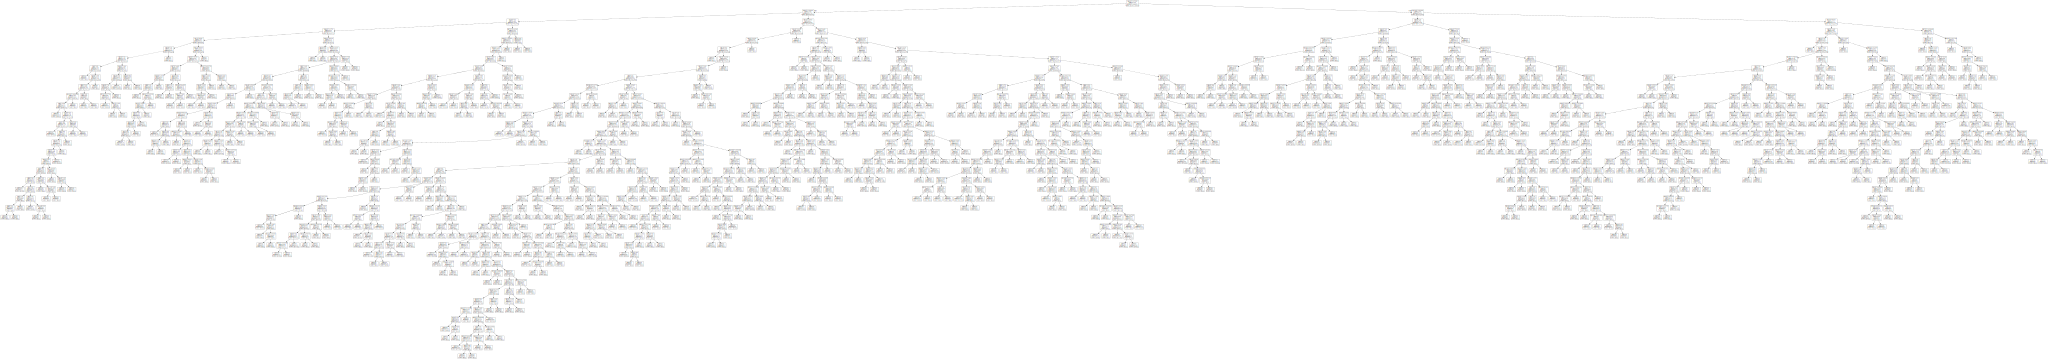

In [0]:
graphviz.Source(dot_graph)